In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn import linear_model
import datetime
from itertools import product
import statsmodels.api as sm
import warnings
from sklearn import preprocessing

%matplotlib inline

In [2]:
# подгружаем данные

# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# временные ряды для этих регионов
df = pd.read_pickle('../loadData/crowdRegs3.pcl')
df.columns = regsDf.regId.values.astype('str')

# словарь с группировкой рядов
tsGroups = np.load('tsGroups.npy').item()

In [3]:
startDate = '2016-01-01 0:0:0'
endDate = '2016-04-30 23:59:59'

Теперь надо подобрать параметры моделей. Для этого можно использовать какой-то один ряд, либо попробовоть усреднять ряды внутри групп и уже для усреднённых рядов подбирать параметры.

Для начала построим и визуально оценим усреднение. Возьмём первую группу.

In [ ]:
gr = 'gr4'
for grName, grVal in tsGroups.items():
    grSeries = df.loc[:,grVal].apply(lambda x: (x - x.mean()), raw = True)
    grSeries = grSeries.apply(lambda x: x /(x.std()), raw = True)
    
    plt.plot()
    grSeries.assign(ms = grSeries.mean(1)).plot(subplots = True,figsize = [15,10])
    plt.title(grName)
    plt.xlim(['2016-01-02','2016-01-31'])

In [28]:
# выберу настроечные ряды руками
fitSeries = {'gr18':'1274','gr19':'1684','gr10':'1333','gr11':'1075','gr12':'2118','gr13':'1387','gr14':'1384','gr15':'1174'}
fitSeries.update({'gr16':'1483','gr17':'1282','gr21':'1184','gr20':'1131','gr23':'1332','gr22':'1580','gr6':'1326','gr7':'1388'})
fitSeries.update({'gr4':'1128','gr2':'1234','gr3':'1231','gr0':'1286','gr1':'1125','gr8':'1181','gr9':'1532'})

In [5]:
# Рядов много, модели обучаются долго, а ресурсов - мало. Поэтому будет подбирать параметры только для малых p и q.
ps = range(1, 5)
d=1
qs = range(1, 5)

Ps = range(0, 3)
D=1
Qs = range(0, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

len(parameters_list)

144

In [6]:
def addFeatures(res, Kw = 6, Ka = 3,verbose = False):    
    # add linear feature
    res = res.assign(hours = (res.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))
    
    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        res['weekCos'+str(ind)]= np.cos(np.pi*res.hours*ind/168);
        res['weekSin'+str(ind)]= np.sin(np.pi*res.hours*ind/168);
    for ind in range(1,Ka+1):
        res['yearCos'+str(ind)]= np.cos(2*np.pi*res.hours*ind/8766);
        res['yearSin'+str(ind)]= np.sin(2*np.pi*res.hours*ind/8766);
        
    # добавляем dummy variables для дней недели
    lbDays = preprocessing.LabelBinarizer()
    lbDays.fit(list(np.arange(6)))
    DoW = pd.DataFrame(lbDays.transform(res.index.dayofweek),columns = ['DayOfWeek_'+str(x) for x in np.arange(6)],
                       index = res.index)      
    res = res.merge(DoW,left_index=True,right_index=True)
 
    # добавляем dummy variables для месяца
    lbMonths = preprocessing.LabelBinarizer()
    lbMonths.fit(list(np.arange(12)))
    Months = pd.DataFrame(lbMonths.transform(res.index.month),columns = ['Month_'+str(x) for x in np.arange(12)],index = res.index)      
    res = res.merge(Months,left_index=True,right_index=True);
    return res

def regression(res, alpha = 0.1, plot = False,verbose = False):
    X = res.drop('trip_count',axis = 1)        
    y = res.loc[:,'trip_count'];
    lassoReg = linear_model.Lasso(alpha = alpha, max_iter = 1e5,fit_intercept = True,random_state = 0);
    lassoReg.fit(X,y)
    y_pr = pd.Series(data = lassoReg.predict(X), index = res.index)
    R = lassoReg.score(X,y);
    print 'R factor is ', R
    
    if plot:
        plt.figure(figsize = [15,10])
        plt.subplot(211)
        plt.plot(y)
        plt.plot(y_pr)
        plt.legend(['Original data','Predicted'])

        plt.subplot(212)
        plt.plot(y-y_pr)
        plt.legend(['Residuals'])
        
    return [y_pr, y-y_pr, lassoReg]

def findHyperParams(ts,pList):
    results = []
    best_aic = float("inf")
    
    # add features
    ts = addFeatures(ts, Kw = 6, Ka = 3)
    # regression
    [s, r, lasso] = regression(ts,alpha = 0.01)
    
    # loop over parameters' list
    for param in pList:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        print('Parameters:', param)
        try:
            mSARIMA=sm.tsa.statespace.SARIMAX(df.loc[startDate:endDate,tsName].to_frame(), order=[param[0], 1, param[1]],
                                          seasonal_order=(param[2], 1, param[3], 24),exog = r).fit(disp=1);
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except Exception as inst:
            print type(inst)     # the exception instance
            print inst           # __str__ allows args to be printed directly
            continue
        aic = mSARIMA.aic
        print('AIC',aic) 
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = mSARIMA
            best_aic = aic
            best_param = param
        results.append([param, mSARIMA.aic])
    return [best_aic,best_param]

In [7]:
#%%time
warnings.filterwarnings('ignore')
paramsDict = {}

for grName, tsName in fitSeries.iteritems():
    
    print 'New groups'
    print grName, tsName
    
    [aic, best_param] = findHyperParams(df.loc[startDate:endDate,tsName].to_frame(name = 'trip_count'),parameters_list)
    
    paramsDict.update({grName: [aic, best_param]})
    print paramsDict
    
warnings.filterwarnings('default')

New groups
gr21 1184
R factor is  0.0239612665475
('Parameters:', (1, 1, 0, 0))
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
('Parameters:', (1, 1, 0, 1))
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
('Parameters:', (1, 1, 0, 2))
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
('Parameters:', (1, 1, 1, 0))
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
('Parameters:', (1, 1, 1, 1))
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
('Parameters:', (1, 1, 1, 2))
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
('

KeyboardInterrupt: 

In [29]:
gr4Params = findHyperParams(df.loc[startDate:endDate,fitSeries.get('gr4')].to_frame(name = 'trip_count'),parameters_list)
#gr20Params = findHyperParams(df.loc[startDate:endDate,fitSeries.get('gr20')].to_frame(name = 'trip_count'),parameters_list)

R factor is  0.116584488889
('Parameters:', (1, 1, 0, 0))
('AIC', 20379.770886501672)
('Parameters:', (1, 1, 0, 1))
('AIC', 19238.408303287179)
('Parameters:', (1, 1, 0, 2))
('AIC', 19111.006374526012)
('Parameters:', (1, 1, 1, 0))
('AIC', 20029.211555338938)
('Parameters:', (1, 1, 1, 1))
('AIC', 19124.935027801828)
('Parameters:', (1, 1, 1, 2))
('AIC', 19117.581396100995)
('Parameters:', (1, 1, 2, 0))
('AIC', 19849.455676129852)
('Parameters:', (1, 1, 2, 1))
('AIC', 19105.826529690818)
('Parameters:', (1, 1, 2, 2))
('AIC', 19116.362720311805)
('Parameters:', (1, 2, 0, 0))
('AIC', 20391.36741595083)
('Parameters:', (1, 2, 0, 1))
('AIC', 19244.446904521883)
('Parameters:', (1, 2, 0, 2))
('AIC', 19119.096871405403)
('Parameters:', (1, 2, 1, 0))
('AIC', 20039.325977566277)
('Parameters:', (1, 2, 1, 1))
('AIC', 19125.532962298654)
('Parameters:', (1, 2, 1, 2))
('AIC', 19124.150768101681)
('Parameters:', (1, 2, 2, 0))
('AIC', 19857.830742223341)
('Parameters:', (1, 2, 2, 1))
('AIC', 19116.1

In [31]:
# обновляем словарь оптимальных параметров для группы # gr4
paramsGroups = np.load('paramsGroups.npy').item()
#paramsGroups.update({'gr20': gr20Params})
paramsGroups.update({'gr4':gr4Params})
np.save('paramsGroups.npy', paramsGroups)

(403224L, 405384L)

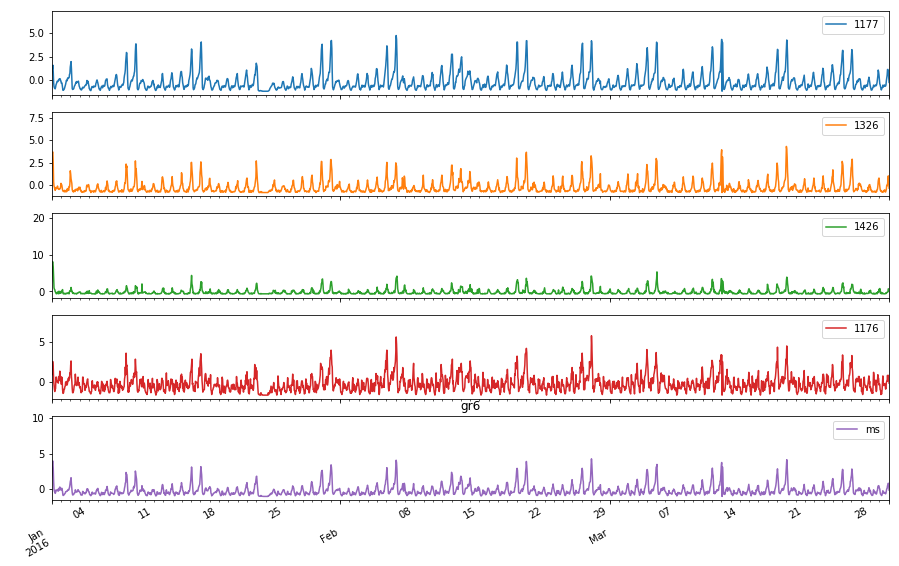

In [37]:
grName = 'gr6'

grSeries = df.loc[:,tsGroups.get(grName)].apply(lambda x: (x - x.mean()), raw = True)
grSeries = grSeries.apply(lambda x: x /(x.std()), raw = True)

grSeries.assign(ms = grSeries.mean(1)).plot(subplots = True,figsize = [15,10])
plt.title(grName)
plt.xlim(['2016-01-01','2016-03-31'])

In [ ]:
# обновляем словарь оптимальных параметров для группы # gr4
grName = 'gr6'
paramsGroups = np.load('paramsGroups.npy').item()
gr22Params = findHyperParams(df.loc[startDate:endDate,fitSeries.get(grName)].to_frame(name = 'trip_count'),parameters_list)
paramsGroups.update({grName:gr22Params})
np.save('paramsGroups.npy', paramsGroups)

R factor is  0.193353762353
('Parameters:', (1, 1, 0, 0))
('AIC', 20460.224964020286)
('Parameters:', (1, 1, 0, 1))
('AIC', 19327.055116299329)
('Parameters:', (1, 1, 0, 2))
